# Data based time series prediction

In [399]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from fbprophet.plot import plot_plotly
import numpy as np
import pylab
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

Load the data

In [429]:
def Real_Data(): return 'https://raw.githubusercontent.com/jgehrcke/covid-19-germany-gae/master/cases-rki-by-state.csv'

observations, trend, seasonability and residuals by decomposition

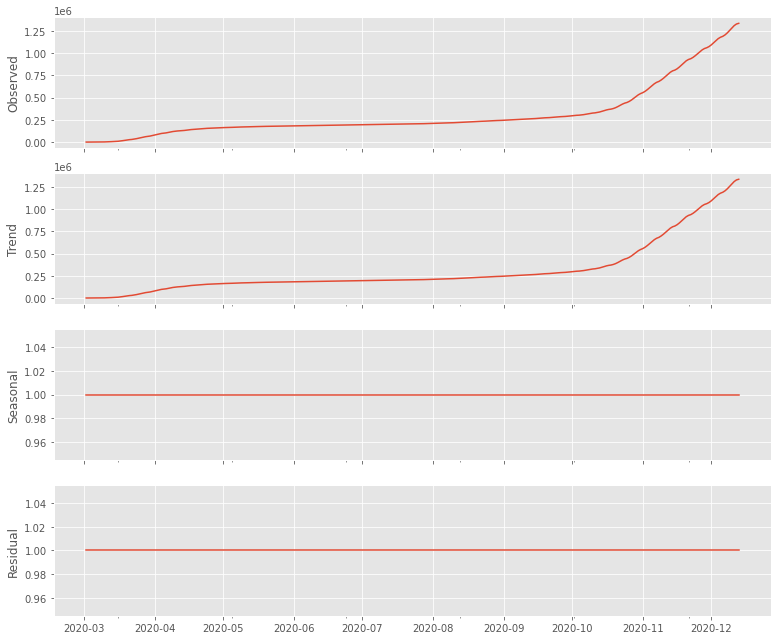

In [401]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

series = pd.read_csv(Real_Data(),  index_col=['time_iso8601'], parse_dates=['time_iso8601'])
series=series.iloc[:, [-1]]
series.index=series.index.date
rcParams['figure.figsize'] = 11, 9
result = seasonal_decompose(series, model='multiplicative', freq=1)
resplot=result.plot( )
plt.show()
resplot.savefig('Seasonal_Decompose.png', dpi=150)

In [402]:
data = pd.read_csv(Real_Data(), index_col=['time_iso8601'], parse_dates=['time_iso8601'], squeeze=True)

In [403]:
data=data.iloc[:, [-1]]
data.index=data.index.date
data

,sum_cases
2020-03-02,209
2020-03-03,294
2020-03-04,448
2020-03-05,632
2020-03-06,818
...,...
2020-12-09,1256888
2020-12-10,1285406
2020-12-11,1311143
2020-12-12,1329498


Real dataset

Get the mean, sd and critical values

In [404]:
type(data)

#convert to time series:
series_value = data.values
type(series_value)

data.describe()

,sum_cases
count,2.870000e+02
mean,3.112437e+05
std,2.952065e+05
min,2.090000e+02
25%,1.726100e+05
50%,2.047010e+05
75%,3.008390e+05
max,1.337078e+06


Plot the values

Making the time series stationary

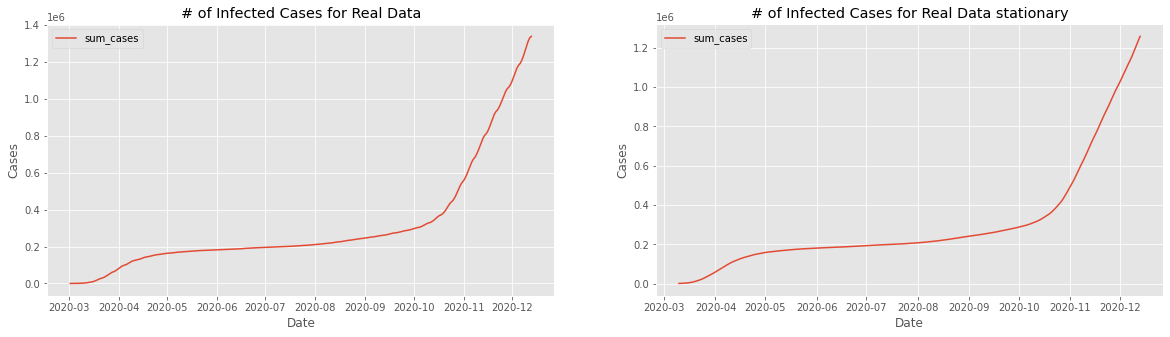

In [405]:
# Apply smoothing function
data_mean = data.rolling(window = 9).mean()
fig, axs = plt.subplots(1, 2, figsize=(20, 5), facecolor='w', edgecolor='k')
data.plot(ax=axs[0])
name = Real_Data.__name__.replace('_', ' ')
axs[0].set_title(f'# of Infected Cases for {name}')
axs[0].set_ylabel('Cases')
axs[0].set_xlabel('Date')
data_mean.plot(ax=axs[1])
axs[1].set_title(f'# of Infected Cases for {name} stationary')
axs[1].set_ylabel('Cases')
axs[1].set_xlabel('Date')
data=data_mean.dropna()

ACF and PACF plots

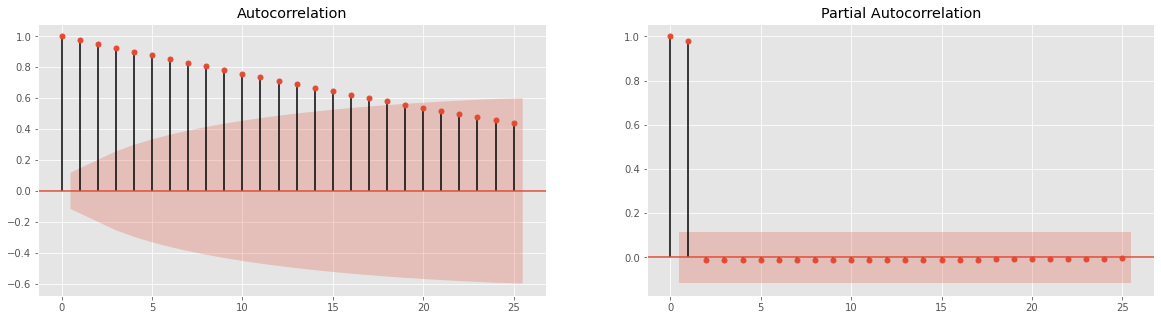

In [406]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig, axs = plt.subplots(1, 2, figsize=(20, 5), facecolor='w', edgecolor='k')
fig=plot_acf(data, ax=axs[0])
fig=plot_pacf(data, ax=axs[1])

In [408]:
data.shape

(279, 1)

Split the data as train and test data

In [409]:
# Split data into train and test sets 
data_train = data[:265]
data_test = data[265:]

In [410]:
data_train.shape

(265, 1)

In [411]:
data_test.shape

(14, 1)

Build the ARIMA Model

In [531]:
from statsmodels.tsa.arima_model import ARIMA

data_model = ARIMA(data_train, order=(2,2,0))
data_model_fit = data_model.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Get the best aic value

In [532]:
data_model_fit.aic

3553.935161329716

Predict the forecast

In [533]:
data_forecast = data_model_fit.forecast(steps = 14)[0]
data_forecast

array([1011611.74798333, 1026757.92311608, 1042416.58128659,
       1058785.78133515, 1075655.54935983, 1092662.43176646,
       1109532.79178166, 1126192.67681897, 1142734.89887464,
       1159311.36968465, 1176033.21322046, 1192927.68807679,
       1209953.98471741, 1227048.68884276])

In [534]:
data_test

,sum_cases
2020-11-30,1.012477e+06
2020-12-01,1.029796e+06
2020-12-02,1.048007e+06
2020-12-03,1.066767e+06
2020-12-04,1.085535e+06
2020-12-05,1.103511e+06
2020-12-06,1.120386e+06
2020-12-07,1.137421e+06
2020-12-08,1.155992e+06
2020-12-09,1.176111e+06


Find metrics like R2, MSE and RMSE

In [535]:
# comparison to the best performing timeseries prediction approach
from sklearn.metrics import mean_squared_error
from math import sqrt
metrics = {"Data":[], "R2":[], "MSE":[], "RMSE":[]}
metrics['Data'].append(name)
metrics['R2'].append(r2_score(np.log(data_test), np.log(data_forecast)))
metrics['MSE'].append(mean_squared_error(np.log(data_test), np.log(data_forecast)))
metrics['RMSE'].append(mean_squared_error(np.log(data_test), np.log(data_forecast),squared=False))
print(metrics)

{'Data': ['Real Data'], 'R2': [0.9555641913194413], 'MSE': [0.00020093125969702265], 'RMSE': [0.014175022387884354]}


Plot the forecast values

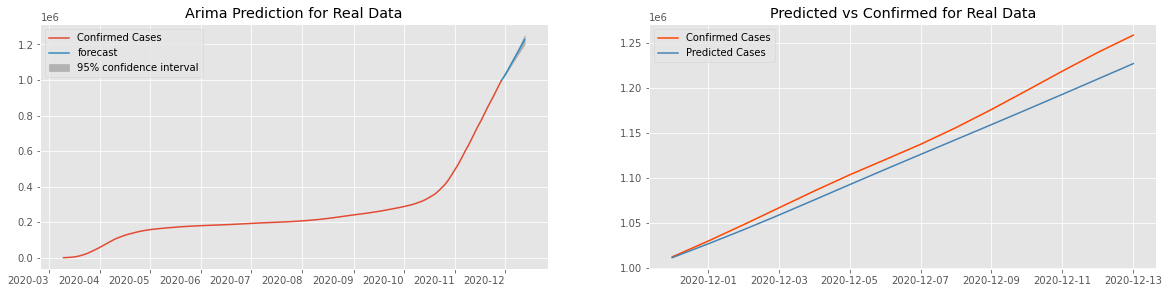

In [536]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5), facecolor='w', edgecolor='k')
axs[0].plot(data_train["sum_cases"], label="Confirmed Cases")
data_model_fit.plot_predict('2020-11-29', '2020-12-13',  ax=axs[0], plot_insample=False)
plt.setp( axs[0].xaxis.get_majorticklabels(), rotation=0 )
axs[0].set_title(f'Arima Prediction for {name}')
compare_df = data_test.copy()
compare_df['yhat']=data_forecast 
axs[1].plot(compare_df['sum_cases'], c='orangered', label ='Confirmed Cases')
axs[1].plot(compare_df['yhat'], c='steelblue', label ='Predicted Cases')
axs[1].set_title(f'Predicted vs Confirmed for {name}')
axs[1].legend()


# PROPHET


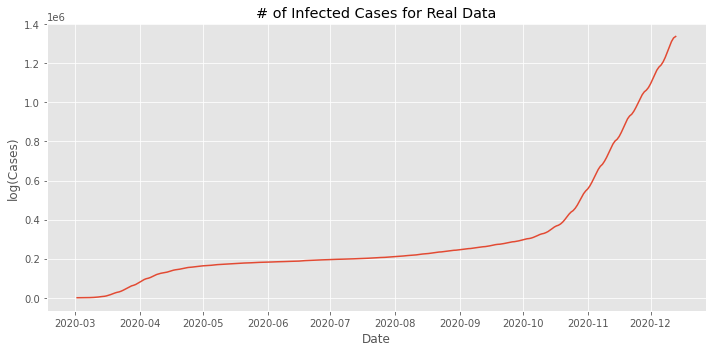

8.294991150161458e-05


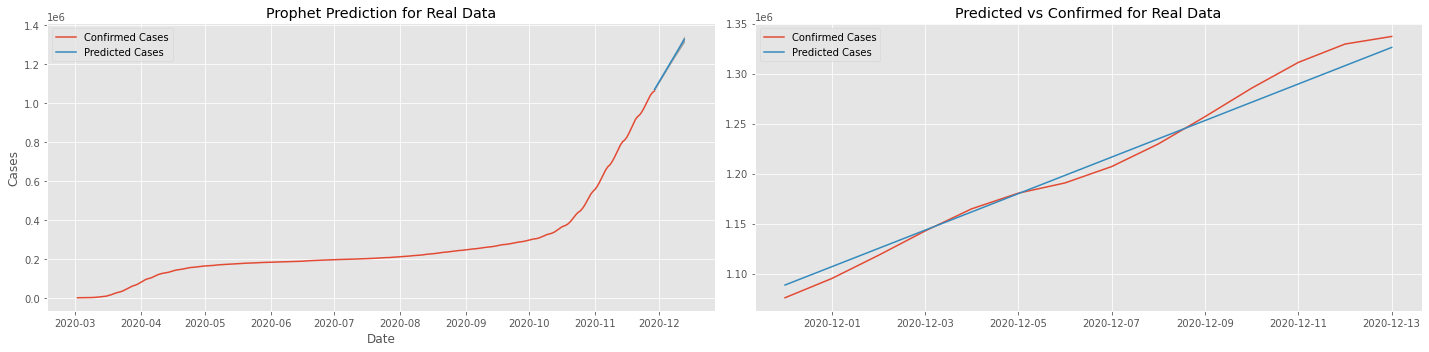

{'Data': ['Real Data'], 'R2': [0.982440044407074], 'MSE': [8.294991150161458e-05], 'RMSE': [0.009107684200806184]}


In [461]:
fig, axs = plt.subplots(figsize=(10, 5), facecolor='w', edgecolor='k')

axs.plot(data.sum_cases)
name = Real_Data.__name__.replace('_', ' ')
axs.set_title(f'# of Infected Cases for {name}')
axs.set_ylabel('log(Cases)')
axs.set_xlabel('Date')

plt.tight_layout()
plt.show()
fig, axs = plt.subplots(1,2, figsize=(20, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
metrics = {"Data":[], "R2":[], "MSE":[], "RMSE":[]}
#cap = 20


data = pd.read_csv(Real_Data(), index_col=['time_iso8601'], parse_dates=['time_iso8601'], squeeze=True)
data=data.iloc[:, [-1]]
data.index=data.index.date
data.index.name ="time_iso8601"
data['sum_cases'] = (data['sum_cases'])
#np.log(data['sum_cases'])
name = Real_Data.__name__.replace('_', ' ')
metrics['Data'].append(name)
train = data[:273]
df_train = data[:273].reset_index()
#df_train['cap'] = cap
df_test = data[273:]
df_train.rename(columns={"time_iso8601": "ds", "sum_cases": "y", 'Cases_per_Day':'Cases_per_Day'}, inplace = True)
# take 273 days -> predict 14  
m = Prophet(daily_seasonality=True, yearly_seasonality=False, weekly_seasonality=False, changepoint_range=0.9).fit(df_train)
future = m.make_future_dataframe(periods=14)
#future['cap'] = cap
forecast = m.predict(future)

#For plotting the forecast components trend, daily
forecast_components=forecast.copy()


forecast.set_index('ds', inplace=True)

viz_df = train.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
train.index = pd.to_datetime(train.index)
connect_date = train.index[-2]

mask = (forecast.index > connect_date)
predict_df = forecast.loc[mask]
viz_df = train.join(predict_df[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
axs[0].plot(viz_df.sum_cases, label="Confirmed Cases")
axs[0].plot(viz_df.yhat, label="Predicted Cases")
axs[0].fill_between(viz_df.index, (viz_df['yhat_upper']), (viz_df['yhat_lower']), alpha=0.5, color='dimgrey')
axs[0].set_title(f'Prophet Prediction for {name}')
# axs[0].plot(data.Cases)
# axs[0].plot(forecast.yhat)
axs[0].set_ylabel('Cases')
axs[0].set_xlabel('Date')
axs[0].legend()



compare_df = df_test.join(forecast[['yhat']], how = 'outer').dropna() 
axs[1].plot(compare_df['sum_cases'], label ='Confirmed Cases')
axs[1].plot(compare_df['yhat'], label ='Predicted Cases')
axs[1].set_title(f'Predicted vs Confirmed for {name}')


print(mean_squared_error(np.log(compare_df.sum_cases), np.log(compare_df.yhat)))
metrics['R2'].append(r2_score(np.log(compare_df.sum_cases), np.log(compare_df.yhat)))
metrics['MSE'].append(mean_squared_error(np.log(compare_df.sum_cases), np.log(compare_df.yhat)))
metrics['RMSE'].append(mean_squared_error(np.log(compare_df.sum_cases), np.log(compare_df.yhat),squared=False))


plt.tight_layout()
plt.legend()
plt.show()

print(metrics)

#### Prophet: forecast components trend, daily and change points





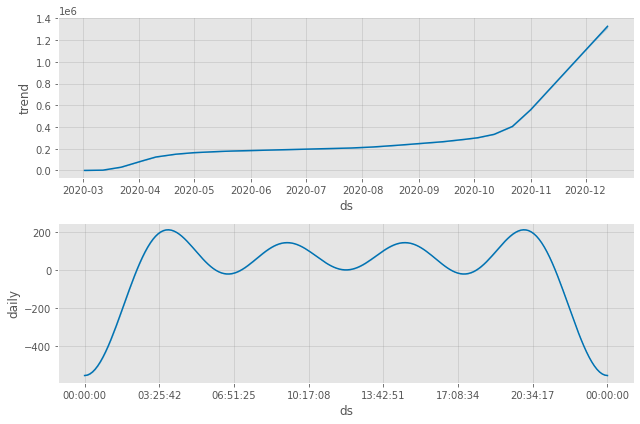

In [462]:
# plotting the forecast components trend, daily
fig = m.plot_components(forecast_components)  

Change Points

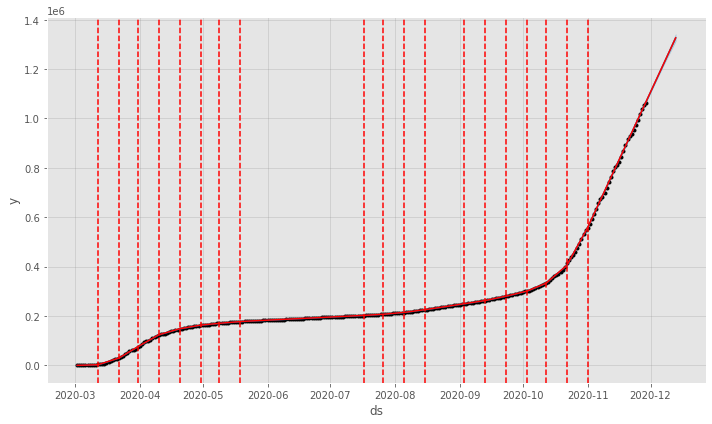

In [463]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast_components)
a=add_changepoints_to_plot(fig.gca(), m, forecast_components)

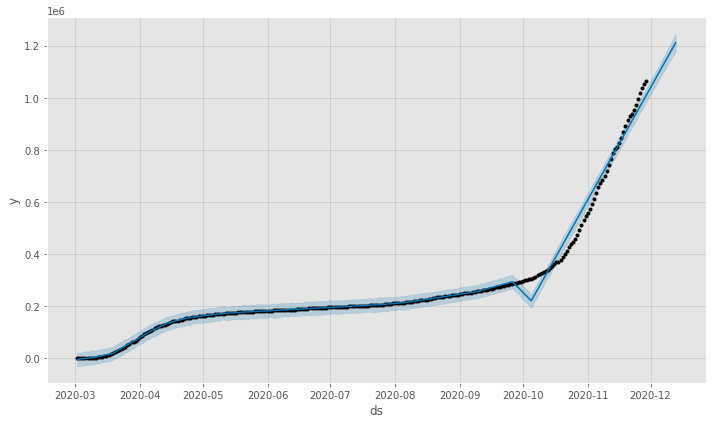

In [464]:
m = Prophet(daily_seasonality=True, yearly_seasonality=False, weekly_seasonality=False,changepoint_prior_scale=0.9)
forecast = m.fit(df_train).predict(future)
fig = m.plot(forecast)

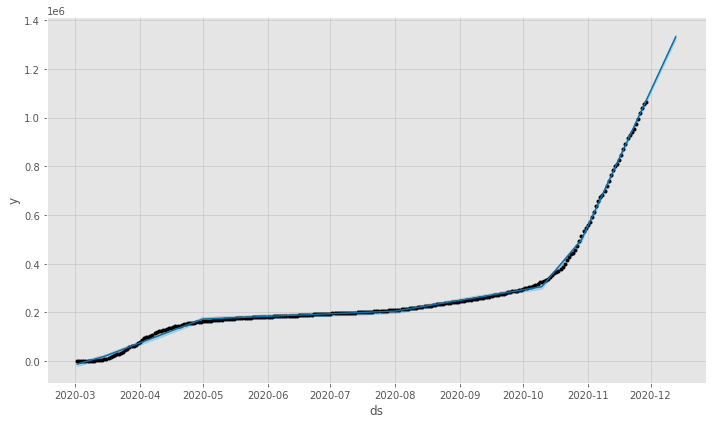

In [498]:
m = Prophet(daily_seasonality=True, yearly_seasonality=False, weekly_seasonality=False,changepoint_prior_scale=0.04, changepoints=['2020-03-15','2020-05-01', '2020-08-01','2020-10-10','2020-10-29'])
forecast = m.fit(df_train).predict(future)
fig = m.plot(forecast)

Prophet With fixed changepoint

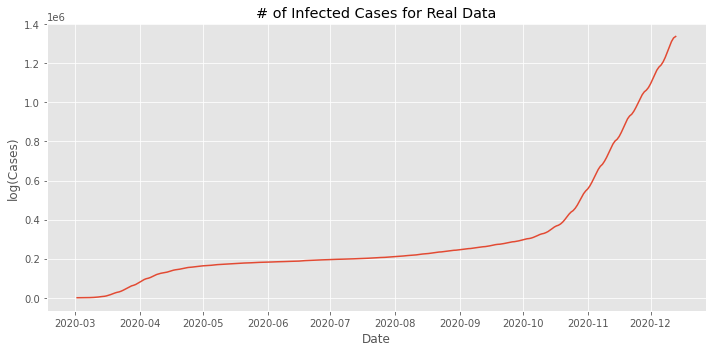

7.803139081231965e-05


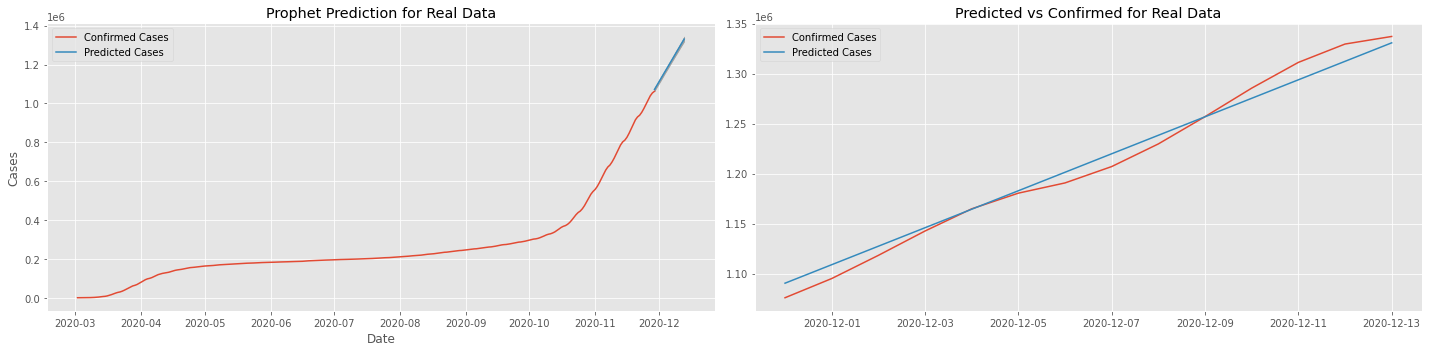

{'Data': ['Real Data'], 'R2': [0.9834812631778165], 'MSE': [7.803139081231965e-05], 'RMSE': [0.008833537842355103]}


In [497]:
fig, axs = plt.subplots(figsize=(10, 5), facecolor='w', edgecolor='k')

axs.plot(data.sum_cases)
name = Real_Data.__name__.replace('_', ' ')
axs.set_title(f'# of Infected Cases for {name}')
axs.set_ylabel('log(Cases)')
axs.set_xlabel('Date')

plt.tight_layout()
plt.show()
fig, axs = plt.subplots(1,2, figsize=(20, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
metrics = {"Data":[], "R2":[], "MSE":[], "RMSE":[]}
#cap = 20


data = pd.read_csv(Real_Data(), index_col=['time_iso8601'], parse_dates=['time_iso8601'], squeeze=True)
data=data.iloc[:, [-1]]
data.index=data.index.date
data.index.name ="time_iso8601"
data['sum_cases'] = (data['sum_cases'])
#np.log(data['sum_cases'])
name = Real_Data.__name__.replace('_', ' ')
metrics['Data'].append(name)
train = data[:273]
df_train = data[:273].reset_index()
#df_train['cap'] = cap
df_test = data[273:]
df_train.rename(columns={"time_iso8601": "ds", "sum_cases": "y", 'Cases_per_Day':'Cases_per_Day'}, inplace = True)
# take 273 days -> predict 14  
m = Prophet(daily_seasonality=True, yearly_seasonality=False, weekly_seasonality=False, changepoint_prior_scale=0.04, changepoints=['2020-03-15','2020-05-01', '2020-08-01','2020-10-10','2020-10-29']).fit(df_train)
future = m.make_future_dataframe(periods=14)
#future['cap'] = cap
forecast = m.predict(future)

#For plotting the forecast components trend, daily
forecast_components=forecast.copy()


forecast.set_index('ds', inplace=True)

viz_df = train.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
train.index = pd.to_datetime(train.index)
connect_date = train.index[-2]

mask = (forecast.index > connect_date)
predict_df = forecast.loc[mask]
viz_df = train.join(predict_df[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
axs[0].plot(viz_df.sum_cases, label="Confirmed Cases")
axs[0].plot(viz_df.yhat, label="Predicted Cases")
axs[0].fill_between(viz_df.index, (viz_df['yhat_upper']), (viz_df['yhat_lower']), alpha=0.5, color='dimgrey')
axs[0].set_title(f'Prophet Prediction for {name}')
# axs[0].plot(data.Cases)
# axs[0].plot(forecast.yhat)
axs[0].set_ylabel('Cases')
axs[0].set_xlabel('Date')
axs[0].legend()



compare_df = df_test.join(forecast[['yhat']], how = 'outer').dropna() 
axs[1].plot(compare_df['sum_cases'], label ='Confirmed Cases')
axs[1].plot(compare_df['yhat'], label ='Predicted Cases')
axs[1].set_title(f'Predicted vs Confirmed for {name}')


print(mean_squared_error(np.log(compare_df.sum_cases), np.log(compare_df.yhat)))
metrics['R2'].append(r2_score(np.log(compare_df.sum_cases), np.log(compare_df.yhat)))
metrics['MSE'].append(mean_squared_error(np.log(compare_df.sum_cases), np.log(compare_df.yhat)))
metrics['RMSE'].append(mean_squared_error(np.log(compare_df.sum_cases), np.log(compare_df.yhat),squared=False))


plt.tight_layout()
plt.legend()
plt.show()

print(metrics)

# LSTM

In [423]:
data = pd.read_csv(Real_Data(), header=0, index_col=0, parse_dates=[0], squeeze=True)
data=data.iloc[:, [-1]]
data.index=data.index.date
name = Real_Data.__name__.replace('_', ' ')

In [537]:

#BASED ON: https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

# frame a sequence as a supervised learning problem
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from pandas import concat
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]
 

In [538]:
# transform data to be stationary
raw_values = data.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-14], supervised_values[-14:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Date=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Date=1, Predicted=1077543.691684, Expected=1075820.000000
Date=2, Predicted=1090243.710037, Expected=1095007.000000
Date=3, Predicted=1118831.587423, Expected=1118187.000000
Date=4, Predicted=1142063.523513, Expected=1142541.000000
Date=5, Predicted=1166083.467668, Expected=1164726.000000
Date=6, Predicted=1182372.051771, Expected=1180395.000000
Date=7, Predicted=1189491.963024, Expected=1190627.000000
Date=8, Predicted=1205548.504139, Expected=1206993.000000
Date=9, Predicted=1228411.948313, Expected=1229632.000000
Date=10, Predicted=1250732.550335, Expected=1256888.000000
Date=11, Predicted=1277891.768031, Expected=1285406.000000
Date=12, Predicted=1302120.967499, Expected=1311143.000000
Date=13, Predicted=1327411.331348, Expected=1329498.000000
Date=14, Predicted=1345925.000075, Expected=1337078.000000


Test RMSE: 4592.636


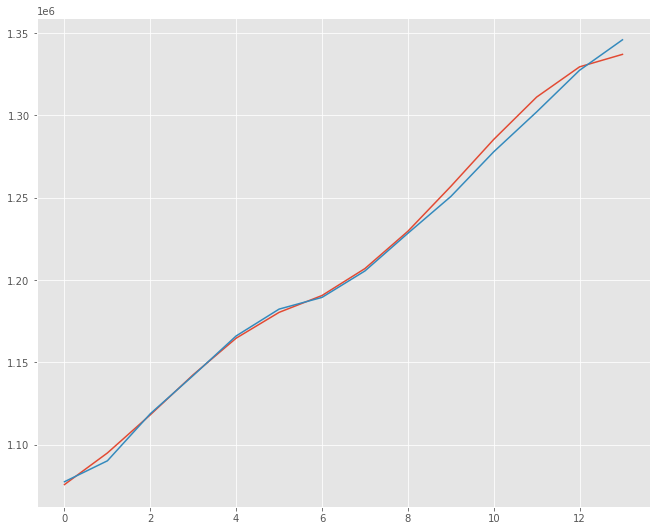

In [539]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-14:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-14:])
pyplot.plot(predictions)
pyplot.show()

In [427]:
metrics = {"Data":[], "R2":[], "MSE":[], "RMSE":[]}
metrics['Data'].append(name)
metrics['R2'].append(r2_score(np.log(raw_values[-14:]), np.log(predictions)))
metrics['MSE'].append(mean_squared_error(np.log(raw_values[-14:]), np.log(predictions)))
metrics['RMSE'].append(mean_squared_error(np.log(raw_values[-14:]), np.log(predictions),squared=False))

print(metrics)

{'Data': ['Real Data'], 'R2': [0.9994471845883398], 'MSE': [2.6113955261035178e-06], 'RMSE': [0.001615981288908853]}
